In [1]:
# Mounted google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# !pip install face-recognition
# !pip install imageio-ffmpeg
#!pip install imageio==2.16.0
#!pip install pillow
#!pip install ffmpeg-python
#!clear

In [8]:
# Imported libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import cv2
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import random
from os import listdir
from os.path import isfile, join

from math import floor
from scipy.ndimage.interpolation import zoom, rotate

import imageio
import face_recognition

In [9]:
# Creating a Dictionary to define Image Dimensions
image_dimensions = {'height':256, 'width':256, 'channels':3}

In [10]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [11]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
  # Created init method
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        # Defined a gradient Descent optimizer variable and set the LR in the constructor
        optimizer = Adam(lr = learning_rate)
        # Defined parameters to compile the model
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    # Create method called init_model
    def init_model(self): 
      #Create a variable X and assigned input layer to pass the image dimensions
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        # Convoulutional Layers
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        # Batch Normalization
        x1 = BatchNormalization()(x1)
        # Max Pooling 
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)

        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [13]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('/content/drive/MyDrive/Colab Notebooks/Meso4_DF')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
## Face extraction
class Video:
    def __init__(self, path):
        self.path = path
        self.container = imageio.get_reader(path, 'ffmpeg')
        self.length = self.container.count_frames()
        self.fps = self.container.get_meta_data()['fps']
    
    def init_head(self):
        self.container.set_image_index(0)
    
    def next_frame(self):
        self.container.get_next_data()
    
    def get(self, key):
        return self.container.get_data(key)
    
    def __call__(self, key):
        return self.get(key)
    
    def __len__(self):
        return self.length


class FaceFinder(Video):
    def __init__(self, path, load_first_face = True):
        super().__init__(path)
        self.faces = {}
        self.coordinates = {}  # stores the face (locations center, rotation, length)
        self.last_frame = self.get(0)
        self.frame_shape = self.last_frame.shape[:2]
        self.last_location = (0, 200, 200, 0)
        if (load_first_face):
            face_positions = face_recognition.face_locations(self.last_frame, number_of_times_to_upsample=2)
            if len(face_positions) > 0:
                self.last_location = face_positions[0]
    
    def load_coordinates(self, filename):
        np_coords = np.load(filename)
        self.coordinates = np_coords.item()
    
    def expand_location_zone(self, loc, margin = 0.2):
        ''' Adds a margin around a frame slice '''
        offset = round(margin * (loc[2] - loc[0]))
        y0 = max(loc[0] - offset, 0)
        x1 = min(loc[1] + offset, self.frame_shape[1])
        y1 = min(loc[2] + offset, self.frame_shape[0])
        x0 = max(loc[3] - offset, 0)
        return (y0, x1, y1, x0)
    
    @staticmethod
    def upsample_location(reduced_location, upsampled_origin, factor):
        ''' Adapt a location to an upsampled image slice '''
        y0, x1, y1, x0 = reduced_location
        Y0 = round(upsampled_origin[0] + y0 * factor)
        X1 = round(upsampled_origin[1] + x1 * factor)
        Y1 = round(upsampled_origin[0] + y1 * factor)
        X0 = round(upsampled_origin[1] + x0 * factor)
        return (Y0, X1, Y1, X0)

    @staticmethod
    def pop_largest_location(location_list):
        max_location = location_list[0]
        max_size = 0
        if len(location_list) > 1:
            for location in location_list:
                size = location[2] - location[0]
                if size > max_size:
                    max_size = size
                    max_location = location
        return max_location
    
    @staticmethod
    def L2(A, B):
        return np.sqrt(np.sum(np.square(A - B)))
    
    def find_coordinates(self, landmark, K = 2.2):
        '''
        We either choose K * distance(eyes, mouth),
        or, if the head is tilted, K * distance(eye 1, eye 2)
        /!\ landmarks coordinates are in (x,y) not (y,x)
        '''
        E1 = np.mean(landmark['left_eye'], axis=0)
        E2 = np.mean(landmark['right_eye'], axis=0)
        E = (E1 + E2) / 2
        N = np.mean(landmark['nose_tip'], axis=0) / 2 + np.mean(landmark['nose_bridge'], axis=0) / 2
        B1 = np.mean(landmark['top_lip'], axis=0)
        B2 = np.mean(landmark['bottom_lip'], axis=0)
        B = (B1 + B2) / 2

        C = N
        l1 = self.L2(E1, E2)
        l2 = self.L2(B, E)
        l = max(l1, l2) * K
        if (B[1] == E[1]):
            if (B[0] > E[0]):
                rot = 90
            else:
                rot = -90
        else:
            rot = np.arctan((B[0] - E[0]) / (B[1] - E[1])) / np.pi * 180
        
        return ((floor(C[1]), floor(C[0])), floor(l), rot)
    
    
    def find_faces(self, resize = 0.5, stop = 0, skipstep = 0, no_face_acceleration_threshold = 3, cut_left = 0, cut_right = -1, use_frameset = False, frameset = []):
        '''
        The core function to extract faces from frames
        using previous frame location and downsampling to accelerate the loop.
        '''
        not_found = 0
        no_face = 0
        no_face_acc = 0
        
        # to only deal with a subset of a video, for instance I-frames only
        if (use_frameset):
            finder_frameset = frameset
        else:
            if (stop != 0):
                finder_frameset = range(0, min(self.length, stop), skipstep + 1)
            else:
                finder_frameset = range(0, self.length, skipstep + 1)
        
        # Quick face finder loop
        for i in finder_frameset:
            # Get frame
            frame = self.get(i)
            if (cut_left != 0 or cut_right != -1):
                frame[:, :cut_left] = 0
                frame[:, cut_right:] = 0            
            
            # Find face in the previously found zone
            potential_location = self.expand_location_zone(self.last_location)
            potential_face_patch = frame[potential_location[0]:potential_location[2], potential_location[3]:potential_location[1]]
            potential_face_patch_origin = (potential_location[0], potential_location[3])
    
            reduced_potential_face_patch = zoom(potential_face_patch, (resize, resize, 1))
            reduced_face_locations = face_recognition.face_locations(reduced_potential_face_patch, model = 'cnn')
            
            if len(reduced_face_locations) > 0:
                no_face_acc = 0  # reset the no_face_acceleration mode accumulator

                reduced_face_location = self.pop_largest_location(reduced_face_locations)
                face_location = self.upsample_location(reduced_face_location,
                                                    potential_face_patch_origin,
                                                    1 / resize)
                self.faces[i] = face_location
                self.last_location = face_location
                
                # extract face rotation, length and center from landmarks
                landmarks = face_recognition.face_landmarks(frame, [face_location])
                if len(landmarks) > 0:
                    # we assume that there is one and only one landmark group
                    self.coordinates[i] = self.find_coordinates(landmarks[0])
            else:
                not_found += 1

                if no_face_acc < no_face_acceleration_threshold:
                    # Look for face in full frame
                    face_locations = face_recognition.face_locations(frame, number_of_times_to_upsample = 2)
                else:
                    # Avoid spending to much time on a long scene without faces
                    reduced_frame = zoom(frame, (resize, resize, 1))
                    face_locations = face_recognition.face_locations(reduced_frame)
                    
                if len(face_locations) > 0:
                    print('Face extraction warning : ', i, '- found face in full frame', face_locations)
                    no_face_acc = 0  # reset the no_face_acceleration mode accumulator
                    
                    face_location = self.pop_largest_location(face_locations)
                    
                    # if was found on a reduced frame, upsample location
                    if no_face_acc > no_face_acceleration_threshold:
                        face_location = self.upsample_location(face_location, (0, 0), 1 / resize)
                    
                    self.faces[i] = face_location
                    self.last_location = face_location
                    
                    # extract face rotation, length and center from landmarks
                    landmarks = face_recognition.face_landmarks(frame, [face_location])
                    if len(landmarks) > 0:
                        self.coordinates[i] = self.find_coordinates(landmarks[0])
                else:
                    print('Face extraction warning : ',i, '- no face')
                    no_face_acc += 1
                    no_face += 1

        print('Face extraction report of', 'not_found :', not_found)
        print('Face extraction report of', 'no_face :', no_face)
        return 0
    
    def get_face(self, i):
        ''' Basic unused face extraction without alignment '''
        frame = self.get(i)
        if i in self.faces:
            loc = self.faces[i]
            patch = frame[loc[0]:loc[2], loc[3]:loc[1]]
            return patch
        return frame
    
    @staticmethod
    def get_image_slice(img, y0, y1, x0, x1):
        '''Get values outside the domain of an image'''
        m, n = img.shape[:2]
        padding = max(-y0, y1-m, -x0, x1-n, 0)
        padded_img = np.pad(img, ((padding, padding), (padding, padding), (0, 0)), 'reflect')
        return padded_img[(padding + y0):(padding + y1),
                        (padding + x0):(padding + x1)]
    
    def get_aligned_face(self, i, l_factor = 1.3):
        '''
        The second core function that converts the data from self.coordinates into an face image.
        '''
        frame = self.get(i)
        if i in self.coordinates:
            c, l, r = self.coordinates[i]
            l = int(l) * l_factor # fine-tuning the face zoom we really want
            dl_ = floor(np.sqrt(2) * l / 2) # largest zone even when rotated
            patch = self.get_image_slice(frame,
                                    floor(c[0] - dl_),
                                    floor(c[0] + dl_),
                                    floor(c[1] - dl_),
                                    floor(c[1] + dl_))
            rotated_patch = rotate(patch, -r, reshape=False)
            # note : dl_ is the center of the patch of length 2dl_
            return self.get_image_slice(rotated_patch,
                                    floor(dl_-l//2),
                                    floor(dl_+l//2),
                                    floor(dl_-l//2),
                                    floor(dl_+l//2))
        return frame


## Face prediction

class FaceBatchGenerator:
    '''
    Made to deal with framesubsets of video.
    '''
    def __init__(self, face_finder, target_size = 256):
        self.finder = face_finder
        self.target_size = target_size
        self.head = 0
        self.length = int(face_finder.length)

    def resize_patch(self, patch):
        m, n = patch.shape[:2]
        return zoom(patch, (self.target_size / m, self.target_size / n, 1))
    
    def next_batch(self, batch_size = 150):
        batch = np.zeros((1, self.target_size, self.target_size, 3))
        stop = min(self.head + batch_size, self.length)
        i = 0
        while (i < batch_size) and (self.head < self.length):
            if self.head in self.finder.coordinates:
                patch = self.finder.get_aligned_face(self.head)
                batch = np.concatenate((batch, np.expand_dims(self.resize_patch(patch), axis = 0)),
                                        axis = 0)
                i += 1
            self.head += 1
        return batch[1:]


def predict_faces(generator, Classifier, batch_size = 50, output_size = 1):
    '''
    Compute predictions for a face batch generator
    '''
    n = len(generator.finder.coordinates.items())
    profile = np.zeros((1, output_size))
    for epoch in range(n // batch_size + 1):
        face_batch = generator.next_batch(batch_size = batch_size)
        prediction = Classifier.predict(face_batch)
        if (len(prediction) > 0):
            profile = np.concatenate((profile, prediction))
    return profile[1:]


def compute_accuracy(Classifier, dirname, frame_subsample_count = 30):
    '''
    Extraction + Prediction over a video
    '''
    filenames = [f for f in listdir(dirname) if isfile(join(dirname, f)) and ((f[-4:] == '.mp4') or (f[-4:] == '.avi') or (f[-4:] == '.mov'))]
    predictions = {}
    
    for vid in filenames:
        print('Dealing with video ', vid)
        
        # Compute face locations and store them in the face finder
        face_finder = FaceFinder(join(dirname, vid), load_first_face = False)
        skipstep = max(floor(face_finder.length / frame_subsample_count), 0)
        face_finder.find_faces(resize=0.5, skipstep = skipstep)
        
        print('Predicting ', vid)
        gen = FaceBatchGenerator(face_finder)
        p = predict_faces(gen, Classifier)
        
        predictions[vid[:-4]]=(np.mean(p > 0.5), p)
        #predictions.append((np.mean(p > 0.5), p))
    return predictions

**Predictions on Video Dataset**

In [18]:
#loading weights for video detection
Classifier = Meso4()
Classifier.load('/content/drive/MyDrive/Colab Notebooks/Meso4_F2F.h5')


#video prediction
predictions = compute_accuracy(Classifier, '/content/drive/MyDrive/Colab Notebooks/DF-videos/c23/videos')
for video_name in predictions:
    print('`{}` video class prediction :'.format(video_name), predictions[video_name][0])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  223_586.mp4
Dealing with video  227_169.mp4
Face extraction warning :  0 - found face in full frame [(174, 961, 308, 827)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  227_169.mp4
Dealing with video  216_164.mp4
Face extraction warning :  0 - found face in full frame [(120, 387, 280, 226)]
Face extraction report of not_found : 1
Face extraction report of no_face : 0
Predicting  216_164.mp4
Dealing with video  215_208.mp4
Face extraction report of not_found : 0
Face extraction report of no_face : 0
Predicting  215_208.mp4
Dealing with video  219_220.mp4
Face extraction report of not_found : 0
Face extraction report of no_face : 0
Predicting  219_220.mp4
Dealing with video  220_219.mp4
Face extraction warning :  0 - found face in full frame [(70, 322, 204, 188), (267, 573, 305, 536)]
Face extraction repor

In [27]:
import pandas as pd
df_video = pd.DataFrame(predictions)

In [28]:
df_video

,000_003,001_870,002_006,004_982,003_000,005_010,007_132,006_002,008_990,009_027,011_805,010_005,013_883,012_026,014_790,016_209,015_919,017_803,018_019,022_489,023_923,020_344,019_018,021_312,027_009,039_058,035_036,028_068,025_067,033_097,032_944,024_073,031_163,029_048,030_193,036_035,040_997,037_072,038_125,034_590,...,969_897,965_948,972_718,968_884,960_999,967_984,971_564,964_174,961_069,970_973,963_879,962_929,966_988,983_113,989_993,987_938,978_975,984_967,976_954,973_970,982_004,980_992,979_875,975_978,977_075,974_953,985_981,981_985,986_994,988_966,995_233,992_980,996_056,994_986,998_561,990_008,993_989,997_040,999_960,991_064
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.964286,0.964286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.965517,1.0,1.0,0.965517,1.0,1.0,1.0,1.0,0.965517,1.0,0.966667,1.0,1.0,0.931034,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.965517,0.964286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.892857,0.928571,0.966667,1.0,0.965517,1.0,0.966667,1.0,0.965517,1.0,0.965517,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.0022919538896530867], [1.0], [1.0], [1.0],...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[7.0431988976083275e-19], [5.411467266110192e...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.245098860143317e-16], [1.0], [1.0], [1.0],...","[[1.0], [1.0], [0.9999998807907104], [1.0], [1...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [

In [50]:
df_video.to_csv('video_predictions.CSV',sep='\t')

In [41]:
df_video1 = pd.read_csv('video_predictions.CSV') 

In [42]:
df_video1.head(5)

,Unnamed: 0,000_003,001_870,002_006,004_982,003_000,005_010,007_132,006_002,008_990,009_027,011_805,010_005,013_883,012_026,014_790,016_209,015_919,017_803,018_019,022_489,023_923,020_344,019_018,021_312,027_009,039_058,035_036,028_068,025_067,033_097,032_944,024_073,031_163,029_048,030_193,036_035,040_997,037_072,038_125,...,969_897,965_948,972_718,968_884,960_999,967_984,971_564,964_174,961_069,970_973,963_879,962_929,966_988,983_113,989_993,987_938,978_975,984_967,976_954,973_970,982_004,980_992,979_875,975_978,977_075,974_953,985_981,981_985,986_994,988_966,995_233,992_980,996_056,994_986,998_561,990_008,993_989,997_040,999_960,991_064
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9642857142857143,0.9642857142857143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.9655172413793104,1.0,1.0,0.9655172413793104,1.0,1.0,1.0,1.0,0.9655172413793104,1.0,0.9666666666666667,1.0,1.0,0.9310344827586207,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9655172413793104,0.9642857142857143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8928571428571429,0.9285714285714286,0.9666666666666667,1.0,0.9655172413793104,1.0,0.9666666666666667,1.0,0.9655172413793104,1.0,0.9655172413793104,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[0.00229195]\n [1. ]\n [1. ]\n ...,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1. ]\n [1. ]\n [1. ]\n ...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[7.04319890e-19]\n [5.41146727e-19]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1. ]\n [1. ]\n [1. ]\n ...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1. ]\n [1. ]\n [1. ]\n ...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...,[[1.24509886e-16]\n [1.00000000e+00]\n [1.0000...,[[1. ]\n [1. ]\n [0.99999988]\n ...,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1.]\n [1....,[[1.]\n [1.]\n [1.]\n

In [43]:
df_video2 = df_video1.apply (pd.to_numeric, errors='coerce')

In [44]:
df_video3 = df_video2.dropna()

In [105]:
df_video3

,Unnamed: 0,000_003,001_870,002_006,004_982,003_000,005_010,007_132,006_002,008_990,009_027,011_805,010_005,013_883,012_026,014_790,016_209,015_919,017_803,018_019,022_489,023_923,020_344,019_018,021_312,027_009,039_058,035_036,028_068,025_067,033_097,032_944,024_073,031_163,029_048,030_193,036_035,040_997,037_072,038_125,...,969_897,965_948,972_718,968_884,960_999,967_984,971_564,964_174,961_069,970_973,963_879,962_929,966_988,983_113,989_993,987_938,978_975,984_967,976_954,973_970,982_004,980_992,979_875,975_978,977_075,974_953,985_981,981_985,986_994,988_966,995_233,992_980,996_056,994_986,998_561,990_008,993_989,997_040,999_960,991_064
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.964286,0.964286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,0.965517,1.0,1.0,0.965517,1.0,1.0,1.0,1.0,0.965517,1.0,0.966667,1.0,1.0,0.931034,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.965517,0.964286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.892857,0.928571,0.966667,1.0,0.965517,1.0,0.966667,1.0,0.965517,1.0,0.965517,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [107]:
df_video3.to_csv('Video_pred.csv')

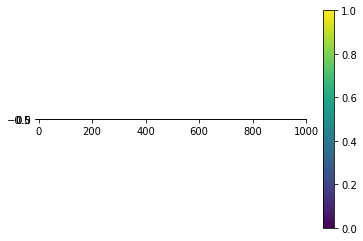

In [99]:
import matplotlib.pyplot as plt
import numpy as np


def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

heatmap2d(df_video3)

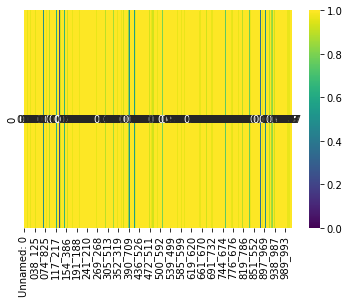

In [96]:
import numpy as np
import seaborn as sns

sns.heatmap(df_video3,cmap='viridis',annot=True)
plt.show()

**Youtube video prediction using URL**

In [ ]:
# installing pytube
#!pip install pytube

In [ ]:
from pytube import YouTube
import os

def downloadYouTube(videourl, path):

    yt = YouTube(videourl)
    yt = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if not os.path.exists(path):
        os.makedirs(path)
    yt.download(path)

In [ ]:
#youtube video prediction using url 
from pytube import YouTube

#saving youtube video to directory 
downloadYouTube('https://www.youtube.com/watch?v=DdZ163jzw4w', '/content/drive/MyDrive/Colab Notebooks/DF-videos/YT')

#predicting
predictions = compute_accuracy(Classifier,'/content/drive/MyDrive/Colab Notebooks/DF-videos/YT') 
for video_name in predictions:
  print('`{}` video class prediction :'.format(video_name), predictions[video_name][0])

Dealing with video  Creepy Prince Harry and Meghan Markle Masks.mp4
Face extraction warning :  108 - found face in full frame [(173, 1148, 405, 917)]
Face extraction warning :  216 - found face in full frame [(269, 527, 334, 462)]
Face extraction warning :  270 - no face
Face extraction warning :  324 - found face in full frame [(306, 693, 384, 615), (392, 942, 470, 865)]
Face extraction warning :  378 - found face in full frame [(144, 485, 278, 352), (256, 924, 368, 813)]
Face extraction warning :  432 - found face in full frame [(259, 573, 296, 536), (242, 1001, 280, 963), (267, 291, 305, 254), (309, 661, 346, 623), (271, 864, 309, 826), (260, 1227, 314, 1173)]
Face extraction warning :  486 - found face in full frame [(241, 564, 286, 519), (218, 1066, 272, 1012), (246, 758, 291, 713), (248, 241, 302, 188), (256, 903, 301, 858), (296, 671, 350, 618), (276, 461, 313, 424)]
Face extraction warning :  540 - found face in full frame [(281, 672, 303, 650)]
Face extraction warning :  594 -

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(predictions)

In [ ]:
df.head(1)

,Creepy Prince Harry and Meghan Markle Masks
0,0.965517


In [ ]:
dfc = pd.read_csv('/content/youtube-video_predictions.CSV') 

In [ ]:
dfc

,Unnamed: 0,Creepy Prince Harry and Meghan Markle Masks
0,0,0.9655172413793104
1,1,[[1.00000000e+00]\n [1.00000000e+00]\n [1.0000...


In [ ]:
df2 = dfc.apply (pd.to_numeric, errors='coerce')

In [ ]:
df2

,Unnamed: 0,Creepy Prince Harry and Meghan Markle Masks
0,0,0.965517
1,1,NaN


In [ ]:
df3 = df2.dropna()

In [ ]:
df3

,Unnamed: 0,Creepy Prince Harry and Meghan Markle Masks
0,0,0.965517


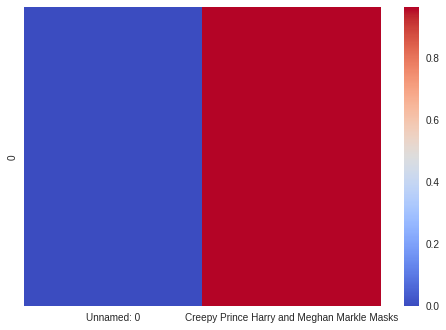

In [ ]:
import seaborn as sns
sns.heatmap(df3,cmap='coolwarm')

**Real-time Webcam capture to check model accuracy**

**Helper Function**

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model.**

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/drive/MyDrive/Colab Notebooks/web-cam-images/Real/photo.jpg


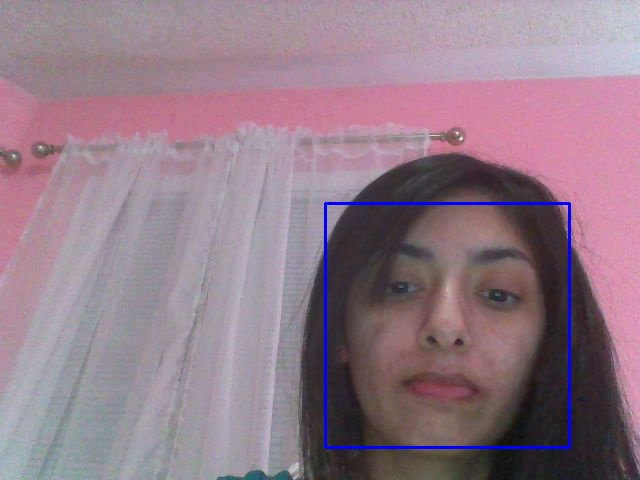

In [ ]:
# Rename photo.jpg everytime you take a new image
# Please change path in order to predict it along with the dataset images
try:
  filename = take_photo('/content/drive/MyDrive/Colab Notebooks/web-cam-images/Real/photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#image generator to predict images over webcam
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/web-cam-images/',
        target_size=(256, 256),
        batch_size= 1,
        class_mode='binary',
        subset='training')

X, y = generator.next()
print('Predicted :', meso.predict(X), '\nReal class :', y)

Found 2 images belonging to 2 classes.
Predicted : [[0.04869372]] 
Real class : [0.]


In [ ]:
# Checking class assignment
generator.class_indices

{'Deep Fake': 0, 'Real': 1}

In [ ]:
#Removing .ipnb_checkpoints
#!rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
#re-generate after removing .ipynb if required
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/web-cam-images/',
        target_size=(256, 256),
        batch_size= 1,
        class_mode='binary',
        subset='training')

X, y = generator.next()
print('Predicted :', meso.predict(X), '\nReal class :', y)

Found 2 images belonging to 2 classes.
Predicted : [[0.98327094]] 
Real class : [1.]


Predicted likelihood: 0.9833
Actual label: 1

Correct prediction: True


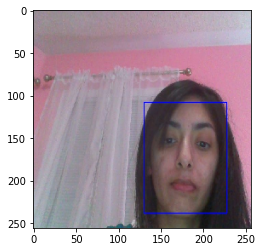

In [ ]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));
#predictions closer to 0 are fake and predictions closer to 1 are real

**Predictions on Image Dataset**

In [ ]:
#image generator to predict images
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/train',
        target_size=(256, 256),
        batch_size= 1,
        class_mode='binary',
        subset='training')

Found 25793 images belonging to 2 classes.


In [ ]:
# Checking class assignment
generator.class_indices

{'fake_image': 0, 'real_image': 1}

In [ ]:
#Removing .ipnb_checkpoints
#!rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
#required to run only if .ipynb_checkpoints exists and is being removed in previos step
# Recreating generator after removing '.ipynb_checkpoints'
#dataGenerator = ImageDataGenerator(rescale=1./255)

#generator = dataGenerator.flow_from_directory(
    #'/content/drive/MyDrive/Colab Notebooks/train',
    #target_size=(256, 256),
    #batch_size=1,
    #class_mode='binary')

# Re-checking class assignment after removing it
#generator.class_indices

Found 25792 images belonging to 2 classes.


{'fake_image': 0, 'real_image': 1}

Predicted likelihood: 0.5337
Actual label: 0

Correct prediction: False


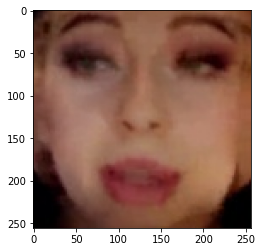

In [ ]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));
#predictions closer to 0 are fake and predictions closer to 1 are real

In [ ]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [ ]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
      print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

In [ ]:
# Creating Plotter function 
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

In [ ]:
# Correct real 
plotter(correct_real, correct_real_pred)

In [ ]:
# Misclassified real
plotter(misclassified_real, misclassified_real_pred)

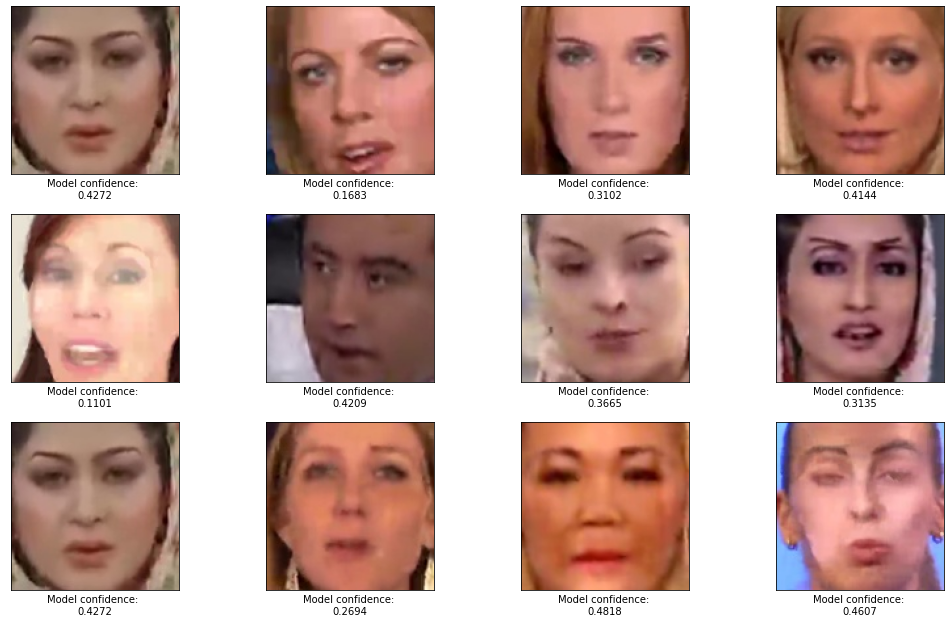

In [ ]:
# Correct deep fake
plotter(correct_deepfake, correct_deepfake_pred)



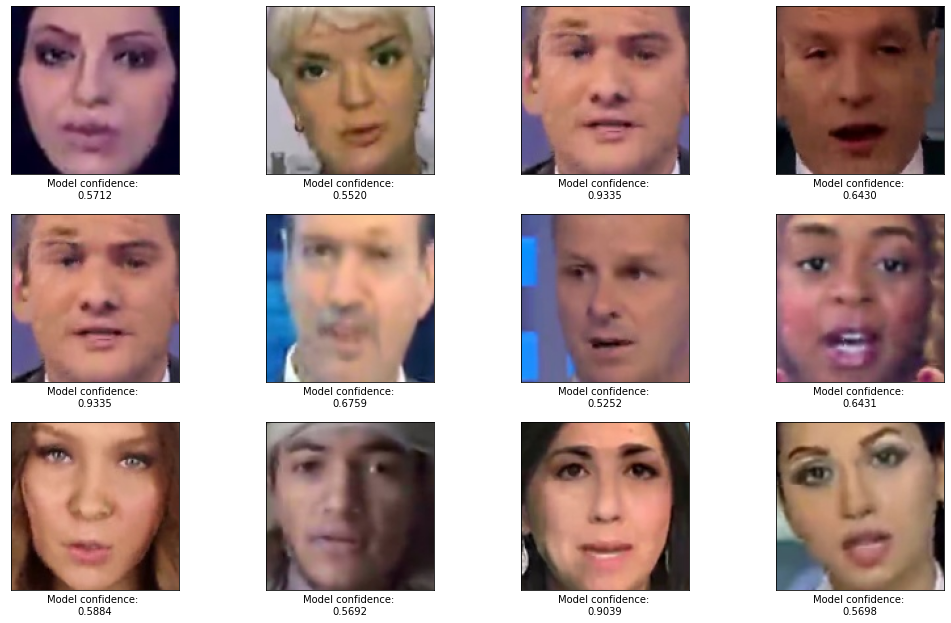

In [ ]:
# Misclassified deep fake
plotter(misclassified_deepfake, misclassified_deepfake_pred)